In [3]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data
from tf_lab.autopredictors.scripts import loading_virt_scan_data as vscan

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
n_points = '1024'

experiment_name = '7_virt_scan_chamfer_2fc_decoder_' + n_points + 'pts_sview_consistent'
do_training = True
do_plotting = True
first_time_running = True
load_model = False

class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]

Give me the class type.
chair


In [5]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/' + n_points, class_syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/7_virt_scan_chamfer_2fc_decoder_1024pts_sview_consistent'

In [6]:
train_id_file = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/shapenet_all-train.txt'
v_scan_top_dir = osp.join(top_data_dir, 'From_Matthias/shapenet_dim32_sdf_pc', class_syn_id)
search_pattern = '__0__.ply'

full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=20)

print '%d files containing complete point clouds were found.' % (len(full_pclouds), )


incomplete_data = vscan.load_single_class_incomplete_dataset(v_scan_top_dir, train_id_file, class_syn_id, 
                                                      full_pclouds, full_model_names, n_threads = 24,
                                                      n_samples = int(n_points), search_pattern=search_pattern)
train_data = incomplete_data

6778 files containing complete point clouds were found.
5000 incomplete point clouds were loaded.


In [18]:
if load_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:
    n_input = [int(n_points), 3]    
    decoder_args = {'layer_sizes': [1024, np.prod(n_input)], 
                    'non_linearity': tf.nn.relu
                   }

    conf = Conf(
                n_input = n_input,
                denoising = True,
                training_epochs = 300,
                batch_size = 50,
                loss = 'chamfer',
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 10,
                learning_rate = 0.00002,
                saver_max_to_keep = 50,
                gauss_augment = {'mu': 0, 'sigma': 0.01},
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args,
                consistent_io = True
               )

    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))

In [36]:
reset_tf_graph()
set_visible_GPUs([1])
ae = PointNetAutoEncoder(experiment_name, conf)

if do_training:
    ae.train(train_data, conf)

else:
    saved_epochs = read_saved_epochs(conf.train_dir)
    ae.restore_model(train_dir, saved_epochs[-1], verbose=True)

mask
Tensor("7_virt_scan_chamfer_2fc_decoder_1024pts_sview_consistent_1/consistent/Softmax:0", shape=(?, 1024), dtype=float32)
sds
Tensor("7_virt_scan_chamfer_2fc_decoder_1024pts_sview_consistent_1/transpose_1:0", shape=(?, 1024, 3), dtype=float32)


InvalidArgumentError: Incompatible shapes: [50,1024] vs. [50,3,1024]
	 [[Node: 7_virt_scan_chamfer_2fc_decoder_1024pts_sview_consistent_1/Mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](7_virt_scan_chamfer_2fc_decoder_1024pts_sview_consistent_1/consistent/Softmax, 7_virt_scan_chamfer_2fc_decoder_1024pts_sview_consistent_1/transpose)]]

Caused by op u'7_virt_scan_chamfer_2fc_decoder_1024pts_sview_consistent_1/Mul', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-b0fe9447af5e>", line 3, in <module>
    ae = PointNetAutoEncoder(experiment_name, conf)
  File "/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/tf_lab/point_clouds/point_net_ae.py", line 52, in __init__
    self.consistent = tf.transpose(tf.multiply(mask, tf.transpose(self.x_reconstr, perm=[0,2,1])), perm=[0,2,1])
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 1613, in mul
    result = _op_def_lib.apply_op("Mul", x=x, y=y, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [50,1024] vs. [50,3,1024]
	 [[Node: 7_virt_scan_chamfer_2fc_decoder_1024pts_sview_consistent_1/Mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](7_virt_scan_chamfer_2fc_decoder_1024pts_sview_consistent_1/consistent/Softmax, 7_virt_scan_chamfer_2fc_decoder_1024pts_sview_consistent_1/transpose)]]


In [11]:
test_id_file = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/shapenet_all-test.txt'
test_data = vscan.load_single_class_incomplete_dataset(v_scan_top_dir, test_id_file, class_syn_id, 
                                                      full_pclouds, full_model_names, n_threads = 24,
                                                      n_samples = int(n_points), search_pattern=search_pattern)

1000 incomplete point clouds were loaded.


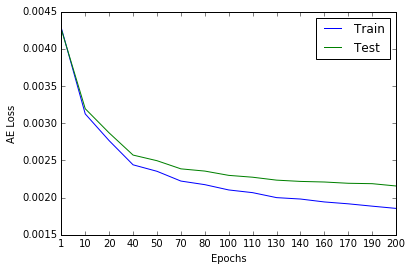

In [31]:
if do_plotting:
    saved_epochs = read_saved_epochs(conf.train_dir)
    plot_epochs = select_first_last_and_k(saved_epochs, 13)
    stats = eval_model(ae, conf, [train_data, test_data], epochs=plot_epochs)
    top_save_dir = osp.join(conf.train_dir, 'model_evaluation')
    plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)
    last_epoch = saved_epochs[-1]
    save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))    
    plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=100)    
    save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=100)